# Supervised Learning (Regression)

In supervised learning, the task is to infer hidden structure from
labeled data, comprised of training examples $\{(x_n, y_n)\}$.
Regression typically means the output $y$ takes continuous values.

We demonstrate with an example in Edward. A webpage version is available at
http://edwardlib.org/tutorials/supervised-regression.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

## Data

Simulate training and test sets of $40$ data points. They comprise of
pairs of inputs $\mathbf{x}_n\in\mathbb{R}^{10}$ and outputs
$y_n\in\mathbb{R}$. They have a linear dependence with normally
distributed noise.

In [2]:
def build_toy_dataset(N, w):
  D = len(w)
  x = np.hstack([np.random.normal(0.0, 2.0, size=(N, D-1)), np.ones((N,1))])
  y = np.dot(x, w) + np.random.normal(0.0, 0.01, size=N)
  return x, y

ed.set_seed(42)

N = 40  # number of data points
D = 5  # number of features

w_true = np.random.randn(D) * 0.5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

## Model

Posit the model as Bayesian linear regression (Murphy, 2012).
It assumes a linear relationship between the inputs
$\mathbf{x}\in\mathbb{R}^D$ and the outputs $y\in\mathbb{R}$.

For a set of $N$ data points $(\mathbf{X},\mathbf{y})=\{(\mathbf{x}_n, y_n)\}$,
the model posits the following distributions:

\begin{align*}
  p(\mathbf{w})
  &=
  \text{Normal}(\mathbf{w} \mid \mathbf{0}, \sigma_w^2\mathbf{I}),
  \\[1.5ex]
  p(b)
  &=
  \text{Normal}(b \mid 0, \sigma_b^2),
  \\
  p(\mathbf{y} \mid \mathbf{w}, b, \mathbf{X})
  &=
  \prod_{n=1}^N
  \text{Normal}(y_n \mid \mathbf{x}_n^\top\mathbf{w} + b, \sigma_y^2).
\end{align*}

The latent variables are the linear model's weights $\mathbf{w}$ and
intercept $b$, also known as the bias.
Assume $\sigma_w^2,\sigma_b^2$ are known prior variances and $\sigma_y^2$ is a
known likelihood variance. The mean of the likelihood is given by a
linear transformation of the inputs $\mathbf{x}_n$.

Let's build the model in Edward, fixing $\sigma_w,\sigma_b,\sigma_y=1$.

In [3]:
X = tf.placeholder(tf.float32, [N, D], name='X')
w = Normal(loc=tf.zeros(D), scale=tf.ones(D), name='w')
y = Normal(loc=ed.dot(X, w), scale=tf.ones(N), name='y')

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

We now turn to inferring the posterior using variational inference.
Define the variational model to be a fully factorized normal across
the weights.

In [5]:
qw_loc = tf.Variable(tf.random_normal([D]), name='qw_loc')
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D]), name='qw_scale'))
qw = Normal(loc=qw_loc, scale=qw_scale, name='qw')

Run variational inference with the Kullback-Leibler divergence, using 
$250$ iterations and $5$ latent variable samples in the algorithm.

In [6]:
import datetime, os
logdir_base = 'C:\\Users\skruz\\temp\\tensorflow\\MLR\\'
log_run = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%dT%H%M%SZ")
logdir = os.path.join(logdir_base, log_run)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [7]:
inference = ed.KLqp({w: qw}, data={X: X_train, y: y_train})

#optimizer = 'adam'
#print("optimizer: {}".format(optimizer))
inference.initialize(n_samples=5, n_iter=250, logdir=logdir)

tf.global_variables_initializer().run()

results = []

for _ in range(inference.n_iter):
  info_dict = inference.update()
  #info_dict['optimizer'] = optimizer
  inference.print_progress(info_dict)
  results.append(info_dict)

inference.finalize()

250/250 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 48.534


In [8]:
inference.latent_vars.keys()

dict_keys([<ed.RandomVariable 'w_2/' shape=(5,) dtype=float32>])

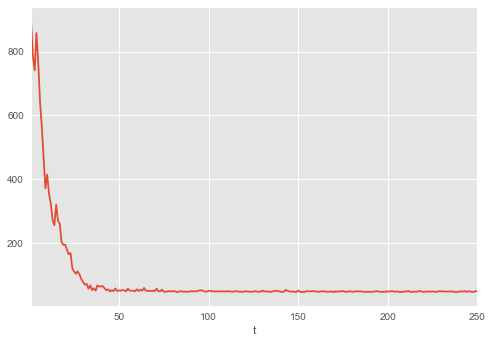

In [10]:
import pandas as pd
pd.DataFrame(results).set_index('t')['loss'].plot()

In this case `KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](http://edwardlib.org/tutorials/klqp).

## Criticism

A standard evaluation for regression is to compare prediction accuracy on
held-out "testing" data. We do this by first forming the posterior predictive
distribution.

In [11]:
y_post = ed.copy(y, {w: qw})
# This is equivalent to
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

With this we can evaluate various quantities using predictions from
the model (posterior predictive).

In [12]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.0114413
Mean absolute error on test data:
0.09976


The trained model makes predictions with low error
(relative to the magnitude of the output).

We can also visualize the fit by comparing data generated with the
prior to data generated with the posterior (on the first feature
dimension).

In [13]:
def visualise(X_data, y_data, w, n_samples=10):
  w_samples = w.sample(n_samples)[:,0].eval()
  plt.scatter(X_data[:, 0], y_data)
  plt.ylim([-10, 10])
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns]
    plt.plot(inputs, output)

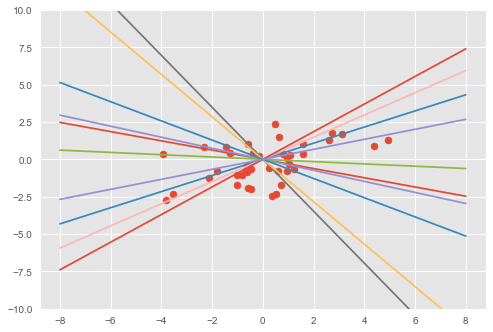

In [14]:
# Visualize samples from the prior.
visualise(X_train, y_train, w)

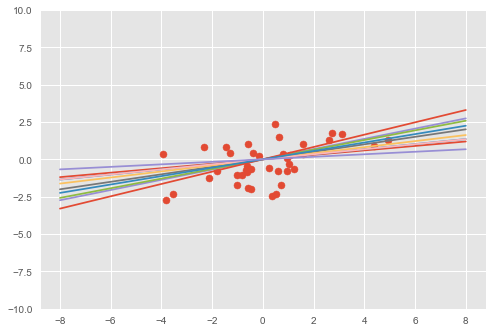

In [15]:
# Visualize samples from the posterior.
visualise(X_train, y_train, qw)

The model has learned a linear relationship between the
first dimension of $\mathbf{x}\in\mathbb{R}^D$ and the outputs
$y\in\mathbb{R}$.

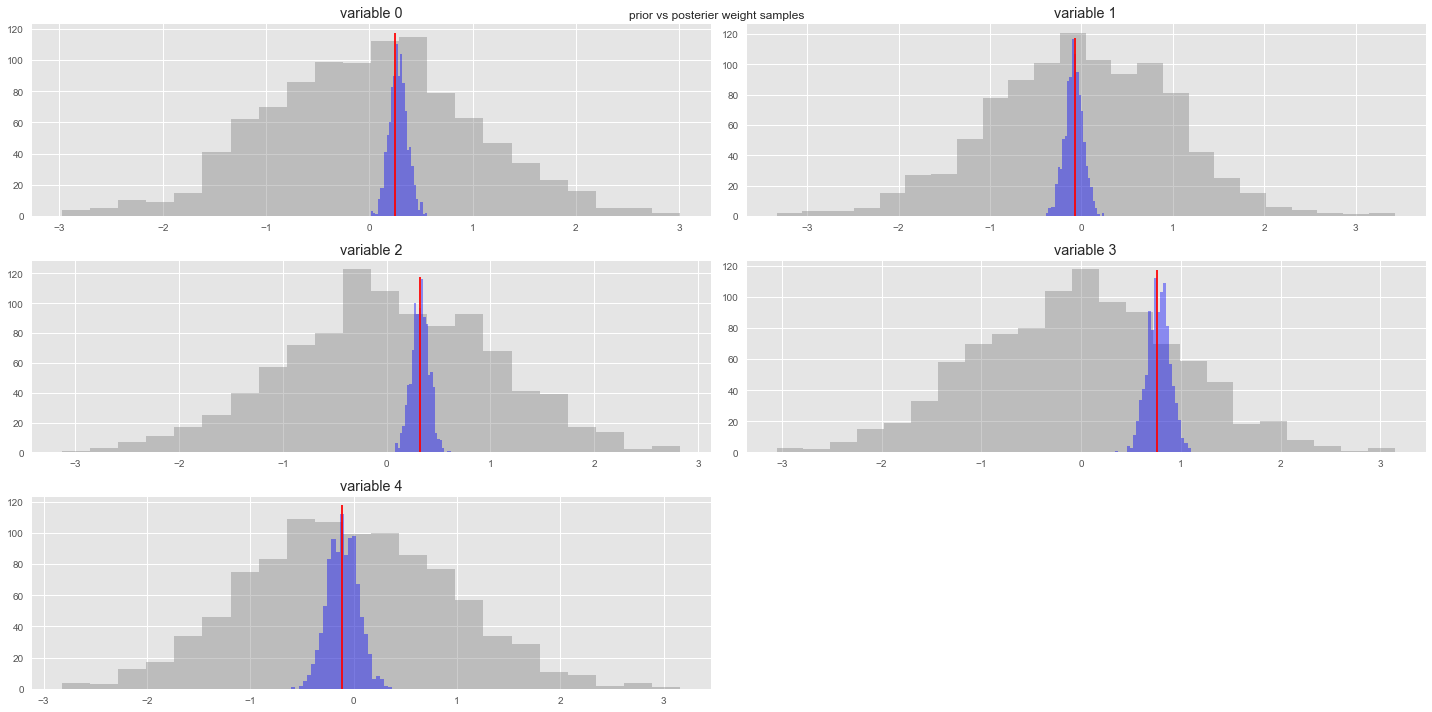

In [17]:
def visualize_dists(w, qw, actual=None, n_samples=1000, figsize=None):
    """
    Creates a grid of histograms of samples from two distributions 'w' and 'qw'
    Optionally creates a red vertical line for each value in 'acutal'
        
    Args:
        w:  the prior variable with an ability to sample  
        qw:  the posterior variable with the same dimensions as w
        actual:  a list-like of known true values, has the same dimension as w
        n_samples (int): the number of samples, default = 1000 
        figsize (tuple): a tuple of the figure size, default is (20, 2*D) where D is the dimension of w 

    Returns:
        matplotlib.figure: A gr
        
    Usage:
        visualize_dists(w, qw, actual=[0.1, 0.0, 0.23, 0.5, 0.3], n_samples=1000)
    """
    import seaborn as sns
    import matplotlib.pylab as plt
    
    w_samples = w.sample(n_samples).eval()
    qw_samples = qw.sample(n_samples).eval()

    D = w_samples.shape[1]

    if figsize is None:
        figsize = (20, D * 2)

    fig = plt.figure(figsize=figsize)
    axes = []
    for i in range(D):
        if i == 0:
            ax = fig.add_subplot(np.ceil(D / 2), 2, i + 1)
        else:
            ax = fig.add_subplot(np.ceil(D / 2), 2, i + 1)
        sns.distplot(w_samples[:, i], kde=False, rug=False, ax=ax, color='grey')
        sns.distplot(qw_samples[:, i], kde=False, rug=False, ax=ax, color='b')
        ax.set_title('variable {}'.format(i))
        axes.append(ax)

    if not actual is None:
        for i in range(D):
            ymin, ymax = ax.get_ylim()
            axes[i].vlines([actual[i]], ymin=ymin, ymax=ymax, color='r')

    fig.tight_layout()
    fig.suptitle('prior vs posterier weight samples')
    return fig



In [22]:
for var in qw.get_variables():
    _ = visualize_dists(w, var, actual=w_true, n_samples=1000)

[<tf.Variable 'qw_scale:0' shape=(5,) dtype=float32_ref>,
 <tf.Variable 'qw_loc:0' shape=(5,) dtype=float32_ref>]

In [24]:
_ = visualize_dists(w, qw_loc, actual=w_true, n_samples=1000)

AttributeError: 'Variable' object has no attribute 'sample'

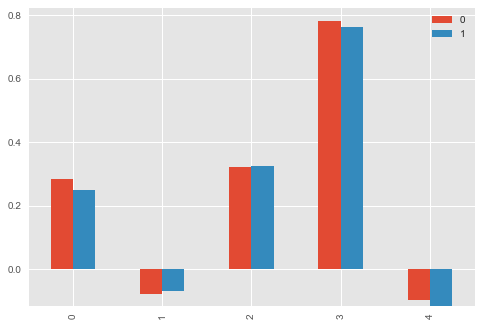

In [36]:
pd.DataFrame(np.vstack([qw_loc.eval(), w_true])).T.plot(kind='bar')

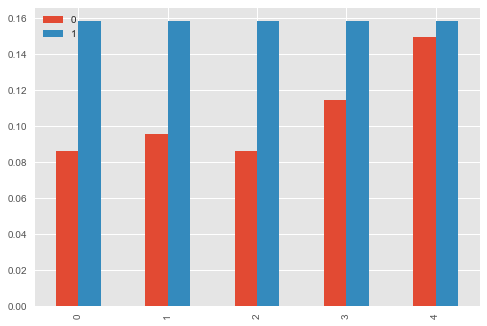

In [51]:
pd.DataFrame(np.vstack([qw_scale.eval()[np.newaxis,:], tf.ones(D).eval()/np.sqrt(N)])).T.plot(kind='bar')